In [6]:
import numpy as np
import os
os.chdir('/Volume/VAD/UAADF/')
import torch
from arguments import parser
from torch.utils.data import DataLoader
from datasets import create_dataset
from accelerate import Accelerator
import matplotlib.pyplot as plt 
import seaborn as sns 
from utils import img_show, img_cvt

from main import torch_seed
import random 

from query_strategies.sampler import SubsetSequentialSampler
from query_strategies.refinement import Refinementer


torch_seed(0)
torch.autograd.set_detect_anomaly(True)
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

default_setting = './configs/benchmark/pc_mvtecloco.yaml'
cfg = parser(jupyter=True, default_setting = default_setting)
cfg.DATASET.batch_size=8
cfg.DATASET.class_name = 'breakfast_box'
cfg.DATASET.params.anomaly_ratio = 0.0

accelerator = Accelerator(
    mixed_precision             = cfg.TRAIN.mixed_precision
)

# load dataset
trainset, testset = create_dataset(
    dataset_name  = cfg.DATASET.dataset_name,
    datadir       = cfg.DATASET.datadir,
    class_name    = cfg.DATASET.class_name,
    img_size      = cfg.DATASET.img_size,
    mean          = cfg.DATASET.mean,
    std           = cfg.DATASET.std,
    aug_info      = cfg.DATASET.aug_info,
    **cfg.DATASET.get('params',{})
)

# make save directory
savedir = os.path.join(
                            cfg.DEFAULT.savedir,
                            cfg.DATASET.dataset_name,
                            cfg.DATASET.class_name
                        )

exp_name         = cfg.DEFAULT.exp_name
method            = cfg.MODEL.method
backbone          = cfg.MODEL.backbone
model_params      = cfg.MODEL.get('params',{})

batch_size       = cfg.DATASET.batch_size
test_batch_size  = cfg.DATASET.test_batch_size
num_workers      = cfg.DATASET.num_workers

opt_name         = cfg.OPTIMIZER.opt_name 
lr               = cfg.OPTIMIZER.lr
opt_params       = cfg.OPTIMIZER.get('params',{})

epochs           = cfg.TRAIN.epochs
log_interval     = cfg.TRAIN.log_interval
use_wandb        = cfg.TRAIN.wandb.use

savedir          = savedir
seed             = cfg.DEFAULT.seed
accelerator      = accelerator
cfg              = cfg

# # define train dataloader
trainloader = DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    num_workers = num_workers,
    shuffle     = False
)

# define test dataloader
testloader = DataLoader(
    dataset     = testset,
    batch_size  = test_batch_size,
    shuffle     = False,
    num_workers = num_workers
)

refinement = Refinementer(
        model          = __import__('models').__dict__[method](
                           backbone = backbone,
                           **model_params
                           ),
        n_query        = cfg.REFINEMENT.n_query,
        dataset        = trainset,
        unrefined_idx  = np.ones(len(trainset)).astype(np.bool8),
        batch_size     = batch_size,
        test_transform = testset.transform,
        num_workers    = num_workers
    )
model = refinement.init_model()
device = cfg.MODEL.params.device

In [7]:
for imgs, labels, gts in trainloader:
    output = model(imgs.to(device))
    loss = model.criterion(output)
model.fit()

Subsampling...: 100%|██████████| 27518/27518 [00:22<00:00, 1228.16it/s]


In [12]:
from utils.metrics import MetricCalculator, loco_auroc

model.eval()
img_level = MetricCalculator(metric_list = ['auroc','average_precision','confusion_matrix'])
pix_level = MetricCalculator(metric_list = ['auroc','average_precision','confusion_matrix','aupro'])

results = {} 
for idx, (images, labels, gts) in enumerate(testloader):
    
    # predict
    if model.__class__.__name__ in ['PatchCore']:
        score, score_map = model.get_score_map(images)
    else:
        with torch.no_grad():
            outputs = model(images)   
            score_map = model.get_score_map(outputs).detach().cpu()
            score = score_map.reshape(score_map.shape[0],-1).max(-1)[0]
            
    # Stack Scoring for metrics 
    pix_level.update(score_map,gts.type(torch.int))
    img_level.update(score, labels.type(torch.int))
    
p_results = pix_level.compute()
i_results = img_level.compute()
    
results['loco_auroc'] = loco_auroc(pix_level,testloader)
results['loco_auroc'] = loco_auroc(img_level,testloader)    

In [ ]:
from copy import deepcopy 

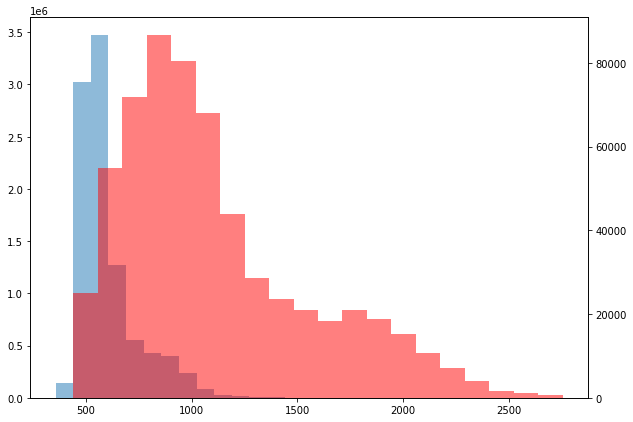

In [13]:
pix_preds_0 = deepcopy(pix_level.preds.flatten())
pix_targets_0 = deepcopy(pix_level.targets.flatten())

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot()

ax1.hist(pix_preds_0[np.where(pix_targets_0 == 0)[0]], bins=20, alpha=0.5)

ax2 = ax1.twinx()
ax2.hist(pix_preds_0[np.where(pix_targets_0 == 1)[0]], color='r', bins=20,alpha=0.5)
plt.show()

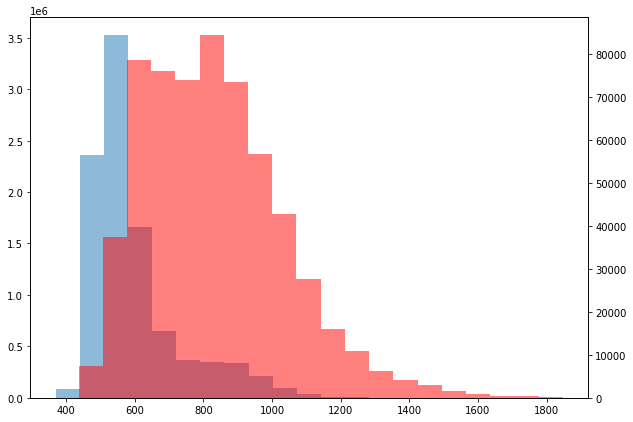

In [14]:
#pix_preds_2 = deepcopy(pix_level.preds.flatten())
#pix_targets_2 = deepcopy(pix_level.targets.flatten())

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot()

ax1.hist(pix_preds_2[np.where(pix_targets_2 == 0)[0]], bins=20, alpha=0.5)

ax2 = ax1.twinx()
ax2.hist(pix_preds_2[np.where(pix_targets_2 == 1)[0]], color='r', bins=20,alpha=0.5)
plt.show()

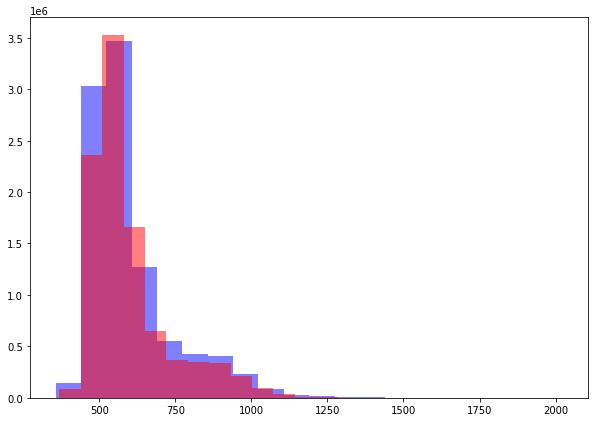

In [21]:
plt.figure(figsize=(10,7))
plt.hist(pix_preds_0[np.where(pix_targets_0 == 0)[0]], bins=20, alpha=0.5,color='b')
plt.hist(pix_preds_2[np.where(pix_targets_2 == 0)[0]], bins=20, alpha=0.5,color='r')

plt.show()

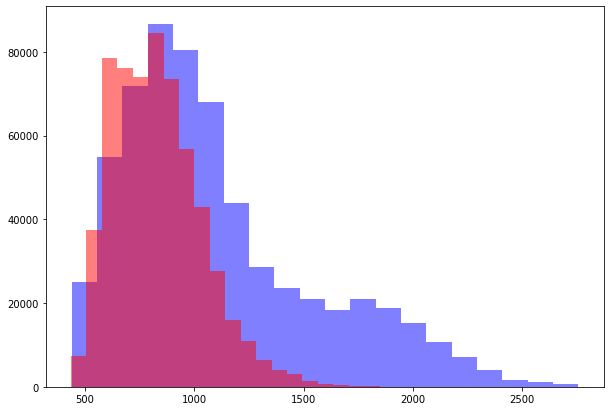

In [20]:
plt.figure(figsize=(10,7))
plt.hist(pix_preds_0[np.where(pix_targets_0 == 1)[0]], bins=20, alpha=0.5,color='b')
plt.hist(pix_preds_2[np.where(pix_targets_2 == 1)[0]], bins=20, alpha=0.5,color='r')

plt.show()